## Proyecto curso de Bigdata
Lo primero de todo es importar las bibliotecas necesarias


In [16]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col
import json
import pytest
import os
import numpy as np
import matplotlib
!pip install ipytest
import ipytest

import pyspark

import pandas as pd

ipytest.autoconfig()



In [17]:

spark = SparkSession.builder.appName("Proyecto-Big-Data").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

25/07/29 22:43:48 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Dataset a elegir
Los dos dataset que elegí son del Departamento de Salud de California, uno sobre el desempleo de la región y el otro sobre la asequibilidad de los alimentos, el proposito es ver como se relacionan entre sí.  
En este paso vamos a crear una función que lea los json y otra para crear los esquemas

In [18]:
def leer_json(ruta_archivo):
    with open(ruta_archivo, 'r') as f:
        return json.load(f)

def crear_esquema(campos):
    mapeo_tipos = {
        "int": IntegerType(),
        "text": StringType()
    }
    return StructType([
        StructField(campo['id'], mapeo_tipos.get(campo['type'], StringType()), True)
        for campo in campos
    ])

Una vez cargado los datos generamos un Dataframe con la funcionalidad de Pyspark y otra función que realice casting de tipos de datos en cada columna

In [19]:
def crear_dataframe(spark, registros, esquema):
    rdd = spark.sparkContext.parallelize(registros)
    return spark.createDataFrame(rdd, esquema)

def convertir_tipos(df, campos):
    mapeo_tipos = {
        "int": IntegerType(),
        "text": StringType()
    }
    for campo in campos:
        tipo_spark = mapeo_tipos.get(campo['type'], StringType())
        df = df.withColumn(campo['id'], col(campo['id']).cast(tipo_spark))
    return df



Necesitamos realizar una limpieza de los datos, ádemas realizamos un print para saber que si hay datos siendo procesados

In [22]:
def limpiar_dataframe(df): #Limpieza básica nada muy complejo
    df = df.dropDuplicates()
    return df.na.fill("Desconocido")

def validar_carga(df, nombre_dataset): #prints
    print(f"\nValidación de {nombre_dataset}:")
    print(f"- Registros cargados: {df.count()}")
    print(f"- Columnas: {len(df.columns)}")
    df.printSchema()
    return df

Por último juntamos en una función todos los distintos procesos que estamos realizando,aqui mismo vamos a correr los procesos para ambos datasets


In [23]:

def cargar_dataset(ruta_archivo, spark, nombre_dataset):
    datos_crudos = leer_json(ruta_archivo)
    campos = datos_crudos['fields']
    registros = datos_crudos['records']  
    esquema = crear_esquema(campos)
    df = crear_dataframe(spark, registros, esquema)
    df = convertir_tipos(df, campos)
    df = limpiar_dataframe(df)
    return validar_carga(df, nombre_dataset)


#Carga de datasets
spark = SparkSession.builder.appName("CargaDatos").getOrCreate()

# Carga modularizada de datasets
df_comida = cargar_dataset("comida.json", spark, "Datos de Comida")
df_desempleo = cargar_dataset("desempleo.json", spark, "Datos de Desempleo")


Validación de Datos de Comida:
- Registros cargados: 14365
- Columnas: 24
root
 |-- _id: integer (nullable = true)
 |-- ind_id: string (nullable = false)
 |-- ind_definition: string (nullable = false)
 |-- reportyear: string (nullable = false)
 |-- race_eth_code: string (nullable = false)
 |-- race_eth_name: string (nullable = false)
 |-- geotype: string (nullable = false)
 |-- geotypevalue: string (nullable = false)
 |-- geoname: string (nullable = false)
 |-- county_name: string (nullable = false)
 |-- county_fips: string (nullable = false)
 |-- region_name: string (nullable = false)
 |-- region_code: string (nullable = false)
 |-- cost_yr: string (nullable = false)
 |-- median_income: string (nullable = false)
 |-- affordability_ratio: string (nullable = false)
 |-- LL95_affordability_ratio: string (nullable = false)
 |-- UL95_affordability_ratio: string (nullable = false)
 |-- se_food_afford: string (nullable = false)
 |-- rse_food_afford: string (nullable = false)
 |-- food_affor

25/07/29 22:47:37 WARN TaskSetManager: Stage 18 contains a task of very large size (1026 KiB). The maximum recommended task size is 1000 KiB.


- Registros cargados: 106411
- Columnas: 23
root
 |-- _id: integer (nullable = true)
 |-- ind_id: string (nullable = false)
 |-- ind_definition: string (nullable = false)
 |-- reportyear: string (nullable = false)
 |-- race_eth_code: string (nullable = false)
 |-- race_eth_name: string (nullable = false)
 |-- geotype: string (nullable = false)
 |-- geotypevalue: string (nullable = false)
 |-- geoname: string (nullable = false)
 |-- county_fips: string (nullable = false)
 |-- county_name: string (nullable = false)
 |-- region_code: string (nullable = false)
 |-- region_name: string (nullable = false)
 |-- Unemployment: string (nullable = false)
 |-- Labor_force: string (nullable = false)
 |-- Unemployment_rate: string (nullable = false)
 |-- ll_95ci: string (nullable = false)
 |-- ul_95ci: string (nullable = false)
 |-- se: string (nullable = false)
 |-- rse: string (nullable = false)
 |-- place_decile: string (nullable = false)
 |-- ca_rr: string (nullable = false)
 |-- version: string

## Pruebas unitarias 
Parte de la verificación necesaria para poder comprobar que todo se importo correctamente es la de hacer pruebas en pytests.
Estas van a ser las pruebas por comprobar:
* Esquema: Va a verificar el nombre de las columnas y los tipos de datos
* Conteo: Que se cargaron todos los registros
* Nulos: Que cambie los valores nulos por "Desconocido"
* Tipos: Que la conversión de los datos sea la correcta 
* Valores: Los no nulos están igual

Tuve muchos incovenientes a la hora de ejecutarlo dentro del visual studio code pero encontré una forma de hacer las pruebas correr dentro del jupyter notebook directamente, la librería que logra esto es ipytest, usando un comando se logra que jupyter trate todo el código como pruebas pytest.
Por eso tenemos más arriba en los entornos el ipytest.config() que configura todo el ambiente, cuando se encuentre con el comando "%%ipytest -v" va a interpretar todo lo que haya más abajo como pytest. Por esto mismo lo hago todo en una celda.

Con el fixtures preparamos las pruebas y generamos los datos de prueba.
Para no tener que probar los miles de datos de california utilizamos 4 datos que van a servir de ejemplo para verificar que la función esta haciendo todo correctamente. Estos datos son del dataset, de los primeros de cada uno, eso significa que si pasan  se están cargando de forma correcta y por ende podemos confiar en el los datos masivos van a servir de la misma manera


In [26]:
%%ipytest -v



@pytest.fixture(scope="module")
def spark():
    spark = SparkSession.builder \
        .master("local[1]") \
        .appName("Pruebas") \
        .getOrCreate()
    yield spark
    spark.stop()

# Datos de comida
@pytest.fixture(scope="module")
def df_comida(spark):
    test_comida = {
        "fields": [
            {"id": "_id", "type": "int"},
            {"id": "ind_id", "type": "text"},
            {"id": "ind_definition", "type": "text"},
            {"id": "reportyear", "type": "text"},
            {"id": "race_eth_code", "type": "text"},
            {"id": "race_eth_name", "type": "text"},
            {"id": "geotype", "type": "text"},
            {"id": "geotypevalue", "type": "text"},
            {"id": "geoname", "type": "text"},
            {"id": "county_name", "type": "text"},
            {"id": "county_fips", "type": "text"},
            {"id": "region_name", "type": "text"},
            {"id": "region_code", "type": "text"},
            {"id": "cost_yr", "type": "text"},
            {"id": "median_income", "type": "text"},
            {"id": "affordability_ratio", "type": "text"},
            {"id": "LL95_affordability_ratio", "type": "text"},
            {"id": "UL95_affordability_ratio", "type": "text"},
            {"id": "se_food_afford", "type": "text"},
            {"id": "rse_food_afford", "type": "text"},
            {"id": "food_afford_decile", "type": "text"},
            {"id": "CA_RR_Affordability", "type": "text"},
            {"id": "ave_fam_size", "type": "text"},
            {"id": "version", "type": "text"}
        ],
        "records": [
            [1,"757","Food affordability for female-headed household with children under 18 years",
             "2006-2010","1","AIAN","CA","06","California",None,None,"California",None,
             "7508.2896552","23777","0.3157795","0.2315166","0.4000425","0.0429913",
             "13.6143419",None,"1.1853472","3.34","2013-04-12 04:33:06.235000"],
            [2,"757","Food affordability for female-headed household with children under 18 years",
             "2006-2010","2","Asian","CA","06","California",None,None,"California",None,
             "7508.2896552","38508","0.19498","0.1830649","0.2068951","0.0060791",
             "3.1178142",None,"0.7318999","3.34","2013-04-12 04:33:06.235000"]
        ]
    }
    
    test_path = "test_comida.json"
    with open(test_path, 'w') as f:
        json.dump(test_comida, f)
    
    df = cargar_dataset(test_path, spark, "Datos de Comida de Prueba")
    yield df
    os.remove(test_path)

# Datos de desempleo 
@pytest.fixture(scope="module")
def df_desempleo(spark):
    test_desempleo = {
        "fields": [
            {"id": "_id", "type": "int"},
            {"id": "ind_id", "type": "text"},
            {"id": "ind_definition", "type": "text"},
            {"id": "reportyear", "type": "text"},
            {"id": "race_eth_code", "type": "text"},
            {"id": "race_eth_name", "type": "text"},
            {"id": "geotype", "type": "text"},
            {"id": "geotypevalue", "type": "text"},
            {"id": "geoname", "type": "text"},
            {"id": "county_fips", "type": "text"},
            {"id": "county_name", "type": "text"},
            {"id": "region_code", "type": "text"},
            {"id": "region_name", "type": "text"},
            {"id": "Unemployment", "type": "text"},
            {"id": "Labor_force", "type": "text"},
            {"id": "Unemployment_rate", "type": "text"},
            {"id": "ll_95ci", "type": "text"},
            {"id": "ul_95ci", "type": "text"},
            {"id": "se", "type": "text"},
            {"id": "rse", "type": "text"},
            {"id": "place_decile", "type": "text"},
            {"id": "ca_rr", "type": "text"},
            {"id": "version", "type": "text"}
        ],
        "records": [
            [4,"290","Unemployment rate","2006-2010","1","AIAN","CA","06","California",
             None,None,None,None,"9673","70286","13.8","12.6085106382979","14.9914893617021",
             "0.60790273556231","4.40509228668341",None,"1","2014-05-22 11:47:47"],
            [5,"290","Unemployment rate","2006-2010","3","AfricanAm","CA","06","California",
             None,None,None,None,"142776","1012992","14.1","13.7425531914894","14.4574468085106",
             "0.182370820668693","1.29341007566449",None,"1","2014-05-22 11:47:47"]
        ]
    }
    
    test_path = "test_desempleo.json"
    with open(test_path, 'w') as f:
        json.dump(test_desempleo, f)
    
    df = cargar_dataset(test_path, spark, "Datos de Desempleo de Prueba")
    yield df
    os.remove(test_path)

# Pruebas para el dataset de comida verifica el esquema del dataset de comida
def test_comida_esquema(df_comida):
    assert set(df_comida.columns) == {
        '_id', 'ind_id', 'ind_definition', 'reportyear', 'race_eth_code', 
        'race_eth_name', 'geotype', 'geotypevalue', 'geoname', 'county_name',
        'county_fips', 'region_name', 'region_code', 'cost_yr', 'median_income',
        'affordability_ratio', 'LL95_affordability_ratio', 'UL95_affordability_ratio',
        'se_food_afford', 'rse_food_afford', 'food_afford_decile', 
        'CA_RR_Affordability', 'ave_fam_size', 'version'
    }
    assert isinstance(df_comida.schema["_id"].dataType, IntegerType)
    assert isinstance(df_comida.schema["ind_definition"].dataType, StringType)
    assert isinstance(df_comida.schema["affordability_ratio"].dataType, StringType)

def test_comida_conteo_registros(df_comida): # Comprueba la cantidad de registros cargados
    assert df_comida.count() == 2

def test_comida_tratamiento_nulos(df_comida): # Valida el manejo de valores nulos que se reemplazaron por "Desconocido
    for col_name in ['county_name', 'county_fips', 'region_code', 'food_afford_decile']:
        nulos = df_comida.filter(col(col_name) == "Desconocido").count()
        assert nulos == 2  # Todos los registros tienen nulos en estas columnas

def test_comida_conversion_tipos(df_comida): # Confirma la conversión correcta de tipos de datos
    sample = df_comida.filter(col("_id") == 1).first()
    assert isinstance(sample._id, int)
    assert isinstance(sample.geoname, str)
    assert isinstance(sample.median_income, str)  

def test_comida_valores_conocidos(df_comida): # Verifica que los valores no nulos se mantienen correctamente
    sample = df_comida.filter(col("_id") == 2).first()
    assert sample.race_eth_name == "Asian"
    assert sample.ave_fam_size == "3.34"
    assert sample.version == "2013-04-12 04:33:06.235000"

# Pruebas para el dataset de desempleo verifica el esquema
def test_desempleo_esquema(df_desempleo):
    assert set(df_desempleo.columns) == {
        '_id', 'ind_id', 'ind_definition', 'reportyear', 'race_eth_code',
        'race_eth_name', 'geotype', 'geotypevalue', 'geoname', 'county_fips',
        'county_name', 'region_code', 'region_name', 'Unemployment', 'Labor_force',
        'Unemployment_rate', 'll_95ci', 'ul_95ci', 'se', 'rse', 'place_decile',
        'ca_rr', 'version'
    }
    assert isinstance(df_desempleo.schema["_id"].dataType, IntegerType)
    assert isinstance(df_desempleo.schema["Unemployment_rate"].dataType, StringType)
    assert isinstance(df_desempleo.schema["version"].dataType, StringType)

def test_desempleo_conteo_registros(df_desempleo): # Comprueba la cantidad de registros cargados
    assert df_desempleo.count() == 2

def test_desempleo_tratamiento_nulos(df_desempleo): #  Valida el manejo de valores nulos que se reemplazaron por "Desconocido
    for col_name in ['county_fips', 'county_name', 'region_code', 'region_name', 'place_decile']:
        nulos = df_desempleo.filter(col(col_name) == "Desconocido").count()
        assert nulos == 2  # Todos los registros tienen nulos en estas columnas

def test_desempleo_conversion_tipos(df_desempleo):
    """Confirma la conversión correcta de tipos de datos"""
    sample = df_desempleo.filter(col("_id") == 4).first()
    assert isinstance(sample._id, int)
    assert isinstance(sample.geoname, str)
    assert isinstance(sample.Unemployment, str)  # Debe ser string según el esquema

def test_desempleo_valores_conocidos(df_desempleo):
    sample = df_desempleo.filter(col("_id") == 5).first()
    assert sample.race_eth_name == "AfricanAm"
    assert sample.Unemployment_rate == "14.1"
    assert sample.ca_rr == "1"

======================================= test session starts ========================================
platform linux -- Python 3.7.10, pytest-7.4.4, pluggy-1.2.0
rootdir: /src
plugins: anyio-3.7.1
collected 10 items

t_4d30e3e2d6ba420cbfdf51a7df283ca7.py .

.........                                             [100%]

========================================= warnings summary =========================================
t_4d30e3e2d6ba420cbfdf51a7df283ca7.py::test_comida_esquema
  /usr/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
    warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
================================== 10 passed, 1 warning in 4.67s ===================================


Con esto comprobamos el esquema, conteo de registros, tratamiento de nulos, valores desconocidos y la conversión de tipos para cada uno de los datasets, con sabemos que se hace un buen tratamiento con los más de mil datos que tiene cada uno. 

# Carga a la base Postgres
Nos conectamos a la base de postgres del contenedor como hemos hecho en incontables trabajos y hacemos dos funciones para el guardado

In [36]:
# Inicializar Spark con el driver JDBC
spark = SparkSession.builder \
    .appName("CargaPostgreSQL") \
    .config("spark.jars", "postgresql-42.5.0.jar") \
    .getOrCreate()

def guardar_comida_postgres(df_comida):
    df_comida.write \
        .format("jdbc") \
        .mode("overwrite") \
        .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
        .option("user", "postgres") \
        .option("password", "pword") \
        .option("dbtable", "datos_comida") \
        .save()
    print("Datos de comida guardados en PostgreSQL")

def guardar_desempleo_postgres(df_desempleo):
    df_desempleo.write \
        .format("jdbc") \
        .mode("overwrite") \
        .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
        .option("user", "postgres") \
        .option("password", "pword") \
        .option("dbtable", "datos_desempleo") \
        .save()
    print(" Datos de desempleo guardados en PostgreSQL")


guardar_comida_postgres(df_comida)
guardar_desempleo_postgres(df_desempleo)


Datos de comida guardados en PostgreSQL


25/07/29 23:54:18 WARN TaskSetManager: Stage 53 contains a task of very large size (1026 KiB). The maximum recommended task size is 1000 KiB.


 Datos de desempleo guardados en PostgreSQL


Para comprobar que si están en la base y no sean solo los prints realizamos funciones de lecturas y una impresión sobre ellas. 

In [56]:

def leer_comida_postgres():
    print("Lectura de comida.json")
    return spark.read \
        .format("jdbc") \
        .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
        .option("user", "postgres") \
        .option("password", "pword") \
        .option("dbtable", "datos_comida") \
        .load()

def leer_desempleo_postgres():
    print("Lectura de postgres.json")
    return spark.read \
        .format("jdbc") \
        .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
        .option("user", "postgres") \
        .option("password", "pword") \
        .option("dbtable", "datos_desempleo") \
        .load()

comida_db = leer_comida_postgres()
comida_db.show(2, vertical=True, truncate=False)

desempleo_db = leer_desempleo_postgres()
desempleo_db.show(2, vertical=True, truncate=False)

#Verificación final
print(f"- Comida: {comida_db.count()} registros cargados")
print(f"- Desempleo: {desempleo_db.count()} registros cargados")

Lectura de comida.json
-RECORD 0-----------------------------------------------------------------------------------------------
 _id                      | 105                                                                         
 ind_id                   | 757                                                                         
 ind_definition           | Food affordability for female-headed household with children under 18 years 
 reportyear               | 2006-2010                                                                   
 race_eth_code            | 6                                                                           
 race_eth_name            | White                                                                       
 geotype                  | CO                                                                          
 geotypevalue             | 06021                                                                       
 geoname                  | Glen

-RECORD 0---------------------------------
 _id               | 59                   
 ind_id            | 290                  
 ind_definition    | Unemployment rate    
 reportyear        | 2006-2010            
 race_eth_code     | 4                    
 race_eth_name     | Latino               
 geotype           | CD                   
 geotypevalue      | 0600191660           
 geoname           | Livermore-Pleasanton 
 county_fips       | 06001                
 county_name       | Alameda              
 region_code       | 01                   
 region_name       | Bay Area             
 Unemployment      | 1263                 
 Labor_force       | 14940                
 Unemployment_rate | 8.5                  
 ll_95ci           | 6.47446808510638     
 ul_95ci           | 10.5255319148936     
 se                | 1.03343465045593     
 rse               | 12.1580547112462     
 place_decile      | Desconocido          
 ca_rr             | 0.80188679245283     
 version   

## Unión de datasets y guardado en la base
Hay un aspecto con los datasets que me gustaría manipular antes de la únion y es que en uno de ellos todos los datos son del 2006 al 2010 y es representado "2006-2010" sin embargo en el otro tiene una representación mixta, a veces tiene el año específico y otras veces el rango de valores, por lo que me gustaría unificar ese dato.
Además el dataset del desempleo cuenta con 106 mil datos que son mucho más que los 14 mil de la asequibilidad de los alimentos, sin embargo hay muchos que tienen practicamente todas sus columnas vacías por lo que antes de la fusión en el dataset más grande me gustaría limpiar aquellos que tengan 7 nulos o más para disminuir un poco la cantidad.


In [58]:

#Convierte años individuales (2006-2010) al formato '2006-2010
def unificar_anios(df):
    años_individuales = ["2006", "2007", "2008", "2009", "2010"]
    return df.withColumn(
        "reportyear",
        when(col("reportyear").isin(años_individuales), "2006-2010")
        .otherwise(col("reportyear"))
    )

# Eliminar datos del dataset de desempleo con 6 o más valores desconocidos
def limpiar_desempleo(df_desempleo):
    columnas = [c for c in df_desempleo.columns if c not in ["_id", "reportyear"]]
    condicion_nulos = sum(when((col(c).isNull()) | (col(c) == "Desconocido"), 1).otherwise(0) for c in columnas)
    
    return df_desempleo.withColumn("nulos_count", condicion_nulos) \
        .filter(col("nulos_count") < 6) \
        .drop("nulos_count")

df_desempleo = unificar_anios(df_desempleo)
df_desempleo_limpio = limpiar_desempleo(df_desempleo)
# Mostrar estadísticas de limpieza
original_count = df_desempleo.count()
limpio_count = df_desempleo_limpio.count()
eliminados = original_count - limpio_count
print(f"  - Registros originales: {original_count}")
print(f"  - Registros eliminados: {eliminados} ({eliminados/original_count:.1%})")
print(f"  - Registros restantes: {limpio_count}")


TypeError: Invalid argument, not a string or column: <generator object limpiar_desempleo.<locals>.<genexpr> at 0x75351285acd0> of type <class 'generator'>. For column literals, use 'lit', 'array', 'struct' or 'create_map' function.

 # Gráficos y estadísticas descriptivas

In [5]:
diabetes_df.summary().show()

NameError: name 'diabetes_df' is not defined

Con el cuadro anterior podemos ver valores intercuartílicos, pero para verlo mejor, se graficarán boxplots.
Algo que desde ya llama la atención es que hay valores atípicos en medidas fisiológicas que no tiene sentido, por ejemplo, que la glucosa, presión arterial, insulina y el IMC tengan valores en 0, lo que puede indicar es que para personas que no se tomó esa medida, se colocó un 0.

## Boxplots y otros gráficos

In [ ]:
import matplotlib.pyplot as plt

cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
        "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
datos = [[] for _ in cols]

for fila in diabetes_df.collect():
    for i, col in enumerate(cols):
        datos[i].append(fila[col])

for feature_data, feature_name in zip(datos, cols):
    plt.figure()
    plt.boxplot(feature_data)
    plt.title(feature_name)
    plt.grid(True)
    plt.tight_layout()
    plt.show()  # Show each plot separately


Se ve que hay variables en las que los _outliers_ pueden aportar contexto al no estar muy lejos de los IQRs, pero otras en las que definitivamente hay valores muy extremos.

In [ ]:
columns_to_clean = ["Glucose", "BMI", "SkinThickness", "BloodPressure"]

iqr_bounds = {}
for col in columns_to_clean:
    q1, q3 = diabetes_df.approxQuantile(col, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    iqr_bounds[col] = (lower_bound, upper_bound)


from pyspark.sql.functions import col


filtered_df = diabetes_df

for col_name, (low, high) in iqr_bounds.items():
    filtered_df = filtered_df.filter((col(col_name) >= low) & (col(col_name) <= high))

## Vectorización y matriz de correlación

In [ ]:
# Para realizar operaciones más detalladas es necesario expresar las filas originales en vectores
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
               "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"],
    outputCol='features')

vector_df = assembler.transform(filtered_df)
vector_df = vector_df.select(['features', 'Outcome'])
vector_df.show()

In [ ]:
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

pearson_matrix = Correlation.corr(vector_df, 'features').collect()[0][0]

sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import SparkSession

standard_scaler = StandardScaler(inputCol="features",outputCol="scaled_features",)

scale_model = standard_scaler.fit(vector_df)

scaled_df = scale_model.transform(vector_df)

scaled_df.show()


In [ ]:
from pyspark.ml.functions import vector_to_array

scaled_df = scaled_df.withColumn("scaled_array", vector_to_array("scaled_features"))

feature_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness","Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

for i, col_name in enumerate(feature_cols):
    scaled_df = scaled_df.withColumn(
        f"{col_name}_scaled",
        col("scaled_array")[i]
    )
    
# (columnas individuales)
final_df = scaled_df.select(
    *[f"{col}_scaled" for col in feature_cols],
    "Outcome"
)

#  quitar sufijo “_scaled”
for col_name in feature_cols:
    final_df = final_df.withColumnRenamed(f"{col_name}_scaled", col_name)

final_df.write \
    .format("jdbc") \
    .mode("overwrite") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "pword") \
    .option("dbtable", "scaledData") \
    .save()


test_df = spark.read \
  .format("jdbc") \
  .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
  .option("user", "postgres") \
  .option("password", "pword") \
  .option("dbtable", "scaledData") \
  .load()

print("Filas en scaledData:", test_df.count())
test_df.show(5)



En la celda de arriba simplemente estamos guardando los datos ya limpios dentro de la base de datos iterando por cada una de las columnas para asegurarse que se mantengan todos los datos de los features, para verificar que se están guardando correctamente podemos ver las 5 primeras filas.
Posteriormente vamos a importar las bibliotecas necesarias para el entrenamiento del modelo y leer los datos de la base.


# Primer modelo (Random Forest)

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

db_url = "jdbc:postgresql://host.docker.internal:5433/postgres"
db_properties = {
    "user": "postgres",
    "password": "pword",
    "driver": "org.postgresql.Driver"
}

df = spark.read.jdbc(
    url=db_url,
    table="scaledData",
    properties=db_properties
)

Elegimos Random Forest porque va muy acorde al tamaño de nuestro dataset que no es muy grande, por lo que es un tiempo de entrenado razonable, incluyendo el hecho de que nos da métricas de suma importancia para identificar que factores influyen más en la predicción de la diabetes. Ahorita vamos a preparar el modelo para entrenamiento así como su validación 


## Obtencion de datos

In [ ]:
#Tomamos los datos
feature_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
                "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

# Dividimos un 80% en datos de entrenamiento y dejamos un 20% para la validación
train_val, validation_test = df.randomSplit([0.8, 0.2], seed=42)

randomforest = RandomForestClassifier(
    featuresCol="features",
    labelCol="Outcome",
    seed=42
)

pipeline = Pipeline(stages=[assembler, randomforest])

evaluator = BinaryClassificationEvaluator(
    labelCol="Outcome",
    metricName="areaUnderROC"
)

# K-Fold Cross Validation con k=5
paramGrid = ParamGridBuilder() \
    .addGrid(randomforest.numTrees, [50, 100, 150]) \
    .addGrid(randomforest.maxDepth, [5, 10, 15]) \
    .addGrid(randomforest.maxBins, [32, 64]) \
    .build()

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,  
    seed=42
)


## Entrenamiento 


In [ ]:

# Entrenar Cross Validation
cv_model = crossval.fit(train_val)


best_model = cv_model.bestModel
best_rf = best_model.stages[-1]
#Reporte del entrenamiento
print("\nMejores parámetros del modelo:")
print(f"Número de árboles: {best_rf.getNumTrees}")
print(f"Profundidad máxima: {best_rf.getMaxDepth()}")
print(f"Número máximo de bins: {best_rf.getMaxBins()}")


En el proceso dura un tiempo considerable ya que promedia los 150 número de arboles con una profundidad de 5.
Una vez entrenado el modelo evaluamos su rendimiento, es importante considerar que la predicción es de una varioable binaria por lo tanto usamos esta validación específica que tiene PysPark

In [ ]:
#Evaluar con la validación final
test_predictions = best_model.transform(validation_test)

# Métricas de evaluación 
evaluator_roc = BinaryClassificationEvaluator(
    labelCol="Outcome",
    metricName="areaUnderROC"
)
roc_auc = evaluator_roc.evaluate(test_predictions)

evaluator_pr = BinaryClassificationEvaluator(
    labelCol="Outcome",
    metricName="areaUnderPR"
)
pr_auc = evaluator_pr.evaluate(test_predictions)

# Evaluador multiclase para precisión
multi_evaluator = MulticlassClassificationEvaluator(
    labelCol="Outcome",
    predictionCol="prediction"
)

accuracy = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "weightedRecall"})
f1 = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "f1"})




# Reporte de métricas
print("\nMétricas en conjunto de validación final:")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Precisión: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Importancia de características
importances = best_rf.featureImportances
importance_dict = {feature: importance for feature, importance in zip(feature_cols, importances)}
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

print("\nImportancia de características:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")

## Guardado en base

In [ ]:
# Guardar predicciones para RF
rf_output = test_predictions.select(
    *feature_cols,
    col("Outcome"),
    col("prediction").alias("prediccion")
)


rf_output.write \
    .format("jdbc") \
    .mode("overwrite") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "pword") \
    .option("dbtable", "modelo1") \
    .save()


print("Predicciones de Random Forest guardadas en tabla 'modelo1'")

## Segundo modelo: Regresión Logística

En este momento realmente hacemos lo mismo que con Random Forest de tomar los datos para el entrenamiento del modelo 
pero decidimos también entrenar con este modelo por varios motivos.
Primero al contrario de RandomForest es mucho más rápido que aunque con este dataset tampoco sea un tiempo irrazonable si se nota bastante la diferencia, y es más facil explicar cada variable por los "odds ratios" para ver que tanto impacta la diabetes y ver si es acorde con RF. Ádemas podemos evitar un poco más el overfitting

In [ ]:
from pyspark.ml.classification import LogisticRegression


db_url = "jdbc:postgresql://host.docker.internal:5433/postgres"
db_properties = {
    "user": "postgres",
    "password": "pword",
    "driver": "org.postgresql.Driver"
}

df = spark.read.jdbc(
    url=db_url,
    table="scaledData",
    properties=db_properties
)

feature_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
                "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

# Dividimos un 80% en datos de entrenamiento y dejamos un 20% para la validación
train_val, test = df.randomSplit([0.8, 0.2], seed=42)


## Preparación

In [ ]:
# Regresión Logística
lr = LogisticRegression(
    featuresCol="features",
    labelCol="Outcome",
    family="binomial",  # diabete o no por eso binaria
    maxIter=100,        
    elasticNetParam=0.8 # Mezcla entre L1 y L2
)

pipeline = Pipeline(stages=[assembler, lr])

evaluator = BinaryClassificationEvaluator(
    labelCol="Outcome",
    metricName="areaUnderROC"
)

# K-Fold Cross Validation con k=5
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.fitIntercept, [True, False]) \
    .build()

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5, 
    seed=42
)

## Entrenamiento

In [ ]:

# Cross Validation
print("Iniciando entrenamiento con Cross Validation...")
cv_model = crossval.fit(train_val)
print("Entrenamiento completado")

# Obtener mejor modelo
best_model = cv_model.bestModel
best_lr = best_model.stages[-1]

print("\nMejores parámetros del modelo:")
print(f"Parámetro de regularización (regParam): {best_lr.getRegParam():.4f}")
print(f"Mezcla L1/L2 (elasticNetParam): {best_lr.getElasticNetParam():.4f}")
print(f"Incluir intercepto: {best_lr.getFitIntercept()}")


## Métricas

In [ ]:

test_predictions = best_model.transform(test)

# Métricas de evaluación
evaluator_roc = BinaryClassificationEvaluator(
    labelCol="Outcome",
    metricName="areaUnderROC"
)
roc_auc = evaluator_roc.evaluate(test_predictions)

evaluator_pr = BinaryClassificationEvaluator(
    labelCol="Outcome",
    metricName="areaUnderPR"
)
pr_auc = evaluator_pr.evaluate(test_predictions)

# Evaluador multiclase para precisión, recall, F1
multi_evaluator = MulticlassClassificationEvaluator(
    labelCol="Outcome",
    predictionCol="prediction"
)
accuracy = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "weightedRecall"})
f1 = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "f1"})

#Reporte de métricas
print("\nMétricas en conjunto de validación final:")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Precisión: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

#Coeficientes del modelo
coefficients = best_lr.coefficients.toArray()
intercept = best_lr.intercept

print("\nCoeficientes del modelo:")
for feature, coef in zip(feature_cols, coefficients):
    print(f"{feature}: {coef:.4f}")
print(f"Intercepto: {intercept:.4f}")

## Guardado en base

In [ ]:
# Guardar predicciones para RF
lf_output = test_predictions.select(
    *feature_cols,
    col("Outcome"),
    col("prediction").alias("prediccion")
)


rf_output.write \
    .format("jdbc") \
    .mode("overwrite") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "pword") \
    .option("dbtable", "modelo2") \
    .save()


print("Predicciones de LogReg guardadas en tabla 'modelo2'")

## Comparación modelos
### Análisis sobre el rendimiento del Random Forest
Lo que nos indica los datos es por un lado el ROC AUC es una capacidad de discriminación entre diabeticos y no diábeticos bastante sólida
El PR AUC en 0.75 es un buen desempeño en un posible desequilibio de clases-
La precisión y el recall es que hay un equilibrio entre falsos positivios y falsos negativos de un 76%
El F1 Score nos confirma lo anterior.

Sobre la importancia de las características podemos concluir lo siguiente, la Glucosa domina el poder predictivo siendo el más fuerte
Seguido por la edad y el BMI, que siguen aportando bastante pero en menos medida, por último la presión sanguínea y el "Skin Thickness" son los que tienen una contribución 
mucho menor.
Lo cual usando la lógica de la enfermedad tiene sentido que el mayor factor sea la glucosa, el peso y edad de la persona.

### Sobre la Regresión Logística
En comparación con RF se ve que regresión logística funciona en todas las métricas, teniendo una mayor discriminación, con así como precisión y mejor balance.
Al igual que en el RF la glucosa, el BMI son los mejores, pero es curioso ver que en este caso posiciona los embarazos por encima de la edad.
Los coeficientes en 0 también es algo que indica que no hay relación alguna entre variables como `BloodPressure` o `SkinThickness` y la variable que se buscaba predecir.

## Confirmación de los datos guardados en la base de datos
Usando el cliente pgAdmin, sabiendo el puerto y las credenciales de la conexión a postgres, se pueden ver las tablas que se almacenaron, e incluso hacer consultas sobre ellas.

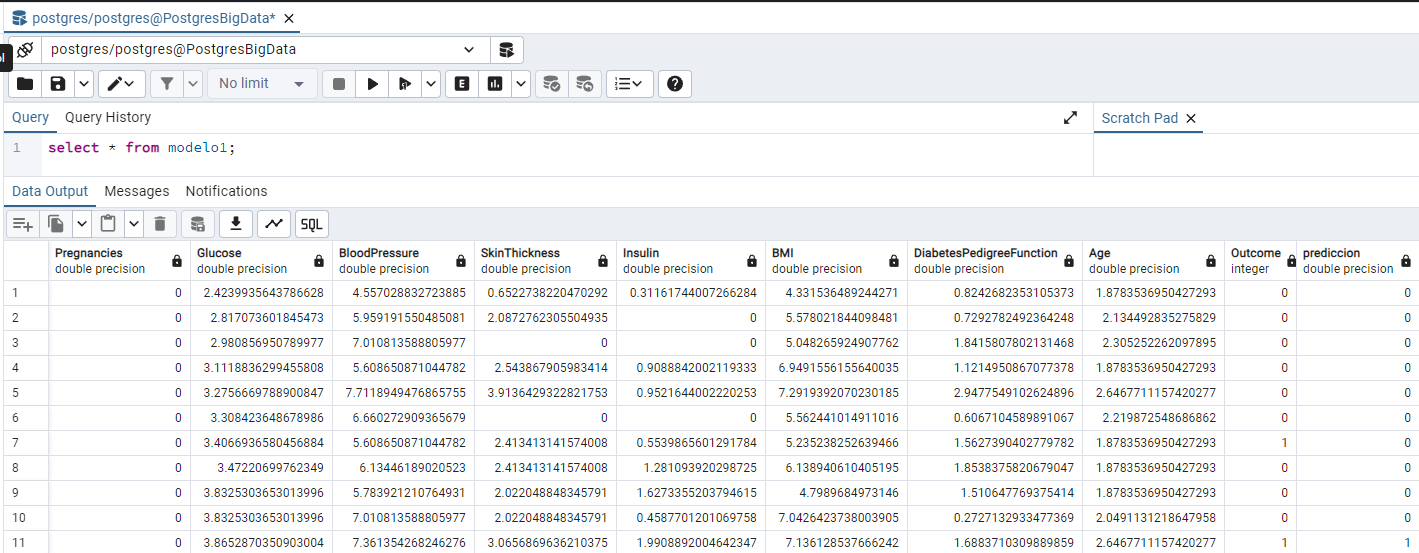

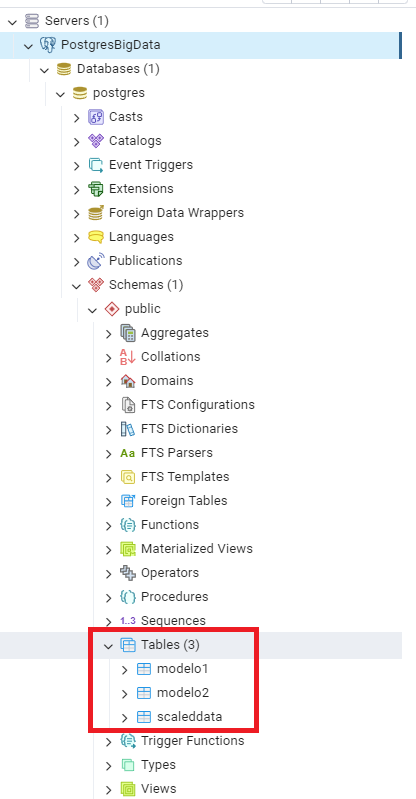